In [1]:
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx 
import torch 
import torch.nn.functional as F 
from torch_geometric.datasets import Planetoid 
from torch_geometric.nn import GATConv 
from torch_geometric.utils import to_networkx, add_self_loops 
from pyvis.network import Network 
import plotly.graph_objects as go

In [2]:
# CONFIG
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_ROOT = "./data"
DATA_NAME = "Cora"
HIDDEN = 8
HEADS_1 = 8
HEADS_2 = 1
LR = 0.005
WEIGHT_DECAY = 5e-4
EPOCHS = 500 
DROPOUT = 0.6
SEED = 42
TOP_K_NEIGHBORS = 8
TOP_EDGES_FOR_INTERACTIVE = 2000
OUTPUT_DIR = "./GAT_Outputs"
os.makedirs(OUTPUT_DIR, exist_ok = True)

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
# Data
dataset = Planetoid(root = DATA_ROOT, name = DATA_NAME)
data = dataset[0].to(DEVICE)
num_features = dataset.num_node_features
num_classes = dataset.num_classes

In [5]:
# Ensure self-loops
data.edge_index, _ = add_self_loops(data.edge_index, num_nodes = data.num_nodes)

In [6]:
# Model
class GATNet(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels, heads1 = 8, heads2 = 1, dropout = 0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hid_channels, heads = heads1, dropout = dropout, concat = True)
        self.conv2 = GATConv(hid_channels * heads1, out_channels, heads = heads2, dropout = dropout, concat = False)
        self.dropout = dropout
               
    def forward(self, x, edge_index, return_attention = False):
        x = F.dropout(x, p = self.dropout, training = self.training)
        if return_attention:
            x1, (edge_index1, attn1) = self.conv1(x, edge_index, return_attention_weights = True)
        else:
            x1 = self.conv1(x, edge_index)
            edge_index1, attn1 = None, None
            
        x1 = F.elu(x1)
        x1 = F.dropout(x1, p = self.dropout, training = self.training)
        
        if return_attention:
            x2, (edge_index2, attn2) = self.conv2(x1, edge_index, return_attention_weights = True)
        else:
            x2 = self.conv2(x1, edge_index)
            edge_index2, attn2 = None, None 
            
        if return_attention:
            return x2, ((edge_index1, attn1), (edge_index2, attn2))
        else:
            return x2 

In [7]:
model = GATNet(in_channels = num_features, hid_channels = HIDDEN, out_channels = num_classes, heads1=HEADS_1, heads2 = HEADS_2, dropout = DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

In [8]:
# Training
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def evaluate():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        accs.append(pred.eq(data.y[mask]).sum().item() / mask.sum().item())
    return accs


best_val = 0
best_test = 0
for epoch in range(1, EPOCHS + 1):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()
    if val_acc > best_val:
        best_val = val_acc
        best_test = test_acc
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}: loss={loss:.4f}, train={train_acc:.4f}, val={val_acc:.4f}, test={test_acc:.4f}")
print(f"Training done. Best val {best_val:.4f}, test at that val {best_test:.4f}")

Epoch 001: loss=1.9918, train=0.4143, val=0.3000, test=0.3130
Epoch 050: loss=0.5729, train=0.9929, val=0.7820, test=0.8140
Epoch 100: loss=0.4261, train=1.0000, val=0.7720, test=0.8080
Epoch 150: loss=0.4124, train=1.0000, val=0.7800, test=0.8010
Epoch 200: loss=0.4380, train=1.0000, val=0.7860, test=0.7960
Epoch 250: loss=0.4432, train=1.0000, val=0.7680, test=0.7990
Epoch 300: loss=0.4784, train=1.0000, val=0.7800, test=0.8050
Epoch 350: loss=0.3018, train=1.0000, val=0.7740, test=0.7900
Epoch 400: loss=0.3609, train=1.0000, val=0.7720, test=0.8020
Epoch 450: loss=0.3244, train=1.0000, val=0.7720, test=0.7850
Epoch 500: loss=0.3654, train=1.0000, val=0.7600, test=0.7980
Training done. Best val 0.8080, test at that val 0.8310


In [10]:
# Extract Attention
model.eval()
with torch.no_grad():
    logits, attention_info = model(data.x, data.edge_index, return_attention = True)
    (edge_index1, attn1), (edge_index2, attn2) = attention_info
    
# attn1 shape: [num_edges, num_heads]
attn1_avg = attn1.mean(dim = 1).cpu().numpy()  # average across heads
edge_index_np = edge_index1.cpu().numpy()
edges = [(int(edge_index_np[0, i]), int(edge_index_np[1, i])) for i in range(edge_index_np.shape[1])]
edge_to_attn = {edges[i]: float(attn1_avg[i]) for i in range(len(edges))}

In [11]:
# Build NetworkX Digraph
G = nx.DiGraph()
G.add_nodes_from(range(data.num_nodes))
for (u, v), w in edge_to_attn.items():
    G.add_edge(u, v, weight = w)
    
# Node labels and colors
labels = data.y.cpu().numpy()
palette = plt.get_cmap("tab10")
node_colors = [palette(int(l) % 10) for l in labels]

# Layout
pos = nx.spring_layout(G, seed = SEED)

Saved: ./GAT_Outputs\cora_attn_whole_graph.png


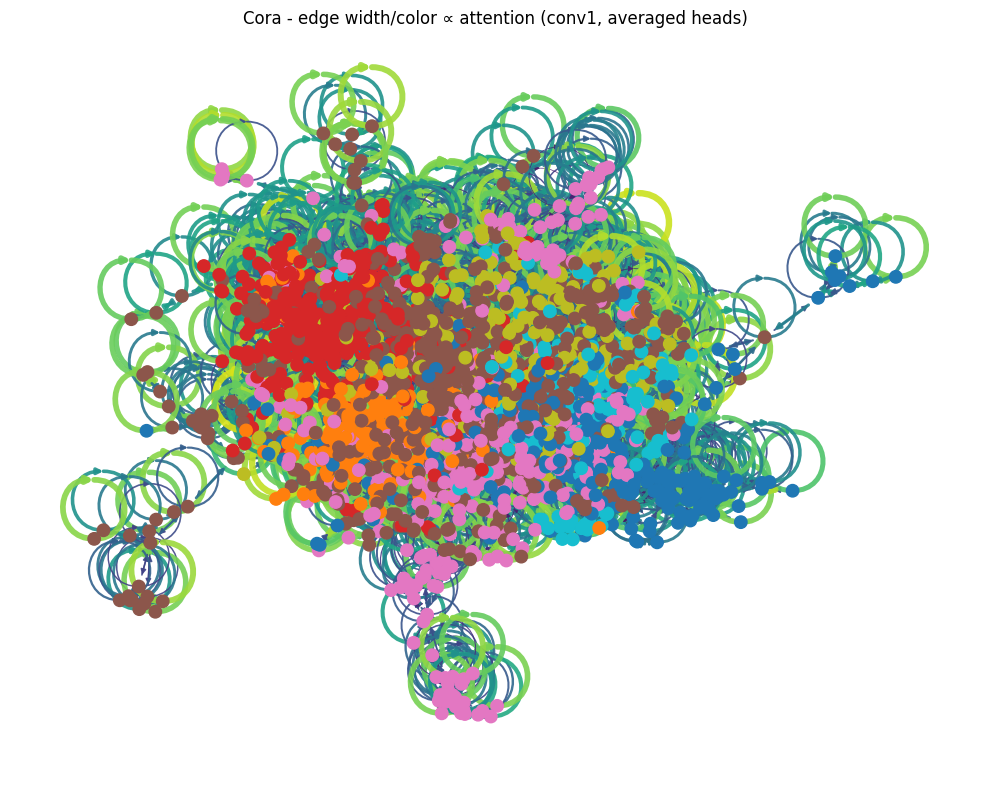

In [14]:
# Static Viz: whole graph (NetworkX + Matplotlib)
attn_vals = np.array([d['weight'] for (u, v, d) in G.edges(data = True)])
if len(attn_vals) > 0:
    attn_min, attn_max = attn_vals.min(), attn_vals.max()
    if math.isclose(attn_min, attn_max):
        widths = np.ones_like(attn_vals) * 2.0
        normed = np.zeros_like(attn_vals)
    else:
        widths = 0.1 + 4.9 * (attn_vals - attn_min) / (attn_max - attn_min)
        normed = (attn_vals - attn_min) / (attn_max - attn_min)
else:
    widths = []
    normed = []
    
edge_colors = plt.cm.viridis(normed)

plt.figure(figsize = (10, 8))
nx.draw_networkx_nodes(G, pos, 
                       node_size = 80,
                       node_color = [labels[i] for i in G.nodes()],
                       cmap = "tab10")
nx.draw_networkx_edges(G, pos, edge_color = edge_colors, width = widths, alpha = 0.9, arrowsize = 8)
plt.title("Cora - edge width/color ∝ attention (conv1, averaged heads)")
plt.axis("off")
plt.tight_layout()
png_whole = os.path.join(OUTPUT_DIR, "cora_attn_whole_graph.png")
plt.savefig(png_whole, dpi=200)
print("Saved:", png_whole)
plt.show()

Saved: ./GAT_Outputs\attn_histogram.png


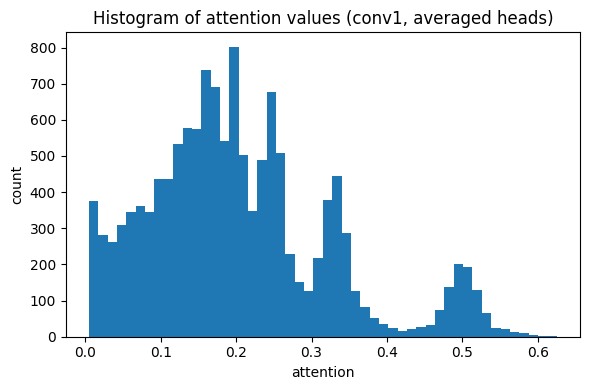

In [13]:
# Histogram of attention
plt.figure(figsize=(6,4))
plt.hist(attn1_avg, bins=50)
plt.title("Histogram of attention values (conv1, averaged heads)")
plt.xlabel("attention"); plt.ylabel("count")
png_hist = os.path.join(OUTPUT_DIR, "attn_histogram.png")
plt.tight_layout(); plt.savefig(png_hist, dpi=200)
print("Saved:", png_hist)

Saved: ./GAT_Outputs\class_attention_heatmap.png


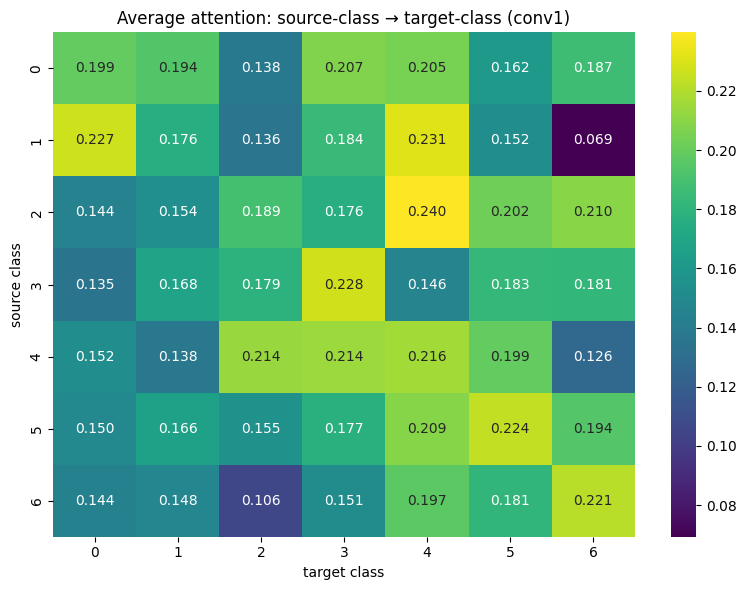

In [ ]:
# Per-class attention matrix 
# We treat edges as directed src->dst. We'll average attention values for edges
# whose source node has class c_src and target has class c_tgt.
class_attn = np.zeros((num_classes, num_classes), dtype=float)
class_counts = np.zeros((num_classes, num_classes), dtype=int)

for (u, v), w in edge_to_attn.items():
    c_u = int(labels[u]); c_v = int(labels[v])
    class_attn[c_u, c_v] += w
    class_counts[c_u, c_v] += 1

# avoid div by zero
class_attn_mean = np.zeros_like(class_attn)
for i in range(num_classes):
    for j in range(num_classes):
        if class_counts[i, j] > 0:
            class_attn_mean[i, j] = class_attn[i, j] / class_counts[i, j]
        else:
            class_attn_mean[i, j] = 0.0

plt.figure(figsize=(8,6))
sns.heatmap(class_attn_mean, annot=True, fmt=".3f", cmap='viridis')
plt.xlabel("target class")
plt.ylabel("source class")
plt.title("Average attention: source-class → target-class (conv1)")
png_class_heat = os.path.join(OUTPUT_DIR, "class_attention_heatmap.png")
plt.tight_layout(); plt.savefig(png_class_heat, dpi=200)
print("Saved:", png_class_heat)

In [19]:
# --------------- Top edges printout ---------------
attn_sorted_idx = np.argsort(attn1_avg)[::-1]
print("Top 20 edges by attention (src->dst : attention_avg):")
for idx in attn_sorted_idx[:20]:
    u = edges[idx][0]; v = edges[idx][1]
    print(f"{u}->{v} : {attn1_avg[idx]:.4f}")

print("All outputs saved in:", OUTPUT_DIR)

Top 20 edges by attention (src->dst : attention_avg):
136->136 : 0.6251
485->62 : 0.6126
739->393 : 0.6064
10->2545 : 0.6017
2374->2374 : 0.5998
2487->2487 : 0.5991
1244->1244 : 0.5939
184->184 : 0.5928
1374->1374 : 0.5891
2505->2505 : 0.5882
1220->1220 : 0.5869
349->419 : 0.5865
119->646 : 0.5857
67->2628 : 0.5845
2488->2488 : 0.5828
1069->1069 : 0.5805
1885->2644 : 0.5787
612->612 : 0.5780
941->941 : 0.5758
220->913 : 0.5758
All outputs saved in: ./GAT_Outputs
